# **Modelling and Evaluation: Regression**

## Objectives

1. Fit and evaluate a regression model which will predict house prices.
2. Answers business criteria 2. Predict prices for client house data.
3. We have agreed an R2 score of at least 0.75 on the train set as well as on the test set.
4. Can predict house prices based on input data from streamlit dashboard. 

## Inputs

1. House_prices_records_clean.csv
2. Inherited_houses_clean.csv
3. Findings of feature engineering notebook

## Outputs

1. Data sets for train, validate and test sets.
2. Feature engineering pipeline.
3. Trained Model.
4. Predictions for client house prices and supporting data.

Please note that all code in this notebook is taken from The Code institute Data Analysis & Machine Learning Toolkit [Data Analysis & Machine Learning Toolkit](https://learn.codeinstitute.net/courses/course-v1:code_institute+CI_DA_ML+2021_Q4/courseware/1f851533cd6a4dcd8a280fd9f37ef4e2/81c19e89e4e94690bd58f738cb7eae91/) lesson.


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir


'/workspace/Heritage-Housing/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")


You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir


'/workspace/Heritage-Housing'

# Load data

Note that we are using the cleaned data sets from the clean data notebook.

In [4]:
import numpy as np
import pandas as pd

house_prices_clean_df = pd.read_csv(
    f"outputs/datasets/clean_data/House_prices_records_clean.csv"
    )


In [5]:
house_prices_clean_df.head()


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,2003.0,...,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1976.0,...,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,2001.0,...,11250,68.0,162.0,42,5,7,920,2001,2002,223500
3,961,0.0,3.0,No,216,ALQ,540,642,Unf,1998.0,...,9550,60.0,0.0,35,5,7,756,1915,1970,140000
4,1145,0.0,4.0,Av,655,GLQ,490,836,RFn,2000.0,...,14260,84.0,350.0,84,5,8,1145,2000,2000,250000


---

# Split data

We need to split our house price data into train, validate and test sets. We will follow the conventional ration of 7:1:2,

First we split into train and test sets.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                                    house_prices_clean_df.drop(
                                        ['SalePrice'], axis=1
                                        ),
                                    house_prices_clean_df['SalePrice'],
                                    test_size=0.2,
                                    random_state=0
                                    )


print("* Train set:", X_train.shape, y_train.shape)
print("*Test set:",  X_test.shape, y_test.shape)


* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


Then we split the test set again. We set the ratio to 0.2 as we want an overall proportion of 7:1:2.

In [6]:
X_train, X_val, y_train, y_val = train_test_split(
                                    X_train,
                                    y_train,
                                    test_size=0.2,
                                    random_state=0
                                    )

print("* Train set:", X_train.shape, y_train.shape)
print("* Validation set:",  X_val.shape, y_val.shape)
print("* Test set:",   X_test.shape, y_test.shape)


* Train set: (934, 21) (934,)
* Validation set: (234, 21) (234,)
* Test set: (292, 21) (292,)


Save data splits.

In [7]:
import os
try:
    os.makedirs(name='outputs/datasets/training_data')
except Exception as e:
    print(e)

X_train.to_csv(f"outputs/datasets/training_data/X_train.csv", index=False)
X_val.to_csv(f"outputs/datasets/training_data/X_val.csv", index=False)
X_test.to_csv(f"outputs/datasets/training_data/X_test.csv", index=False)
y_train.to_csv(f"outputs/datasets/training_data/y_train.csv", index=False)
y_val.to_csv(f"outputs/datasets/training_data/y_val.csv", index=False)
y_test.to_csv(f"outputs/datasets/training_data/y_test.csv", index=False)


# Pipeline

We apply the feature engineering steps outlined in the notebook

In [8]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropFeatures
from feature_engine.encoding import OrdinalEncoder
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import StandardScaler


pipeline = Pipeline([
    ('drop_features', DropFeatures(features_to_drop=['1stFlrSF',
                                                     '2ndFlrSF',
                                                     'GarageArea',
                                                     'GarageYrBlt',
                                                     'YearBuilt'])),
    ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='ordered',
                                                 variables=['BsmtExposure',
                                                            'BsmtFinType1',
                                                            'GarageFinish',
                                                            'KitchenQual'])),

    ('pt', vt.PowerTransformer(variables=['BedroomAbvGr',
                                          'BsmtFinSF1',
                                          'BsmtUnfSF',
                                          'GrLivArea',
                                          'LotArea',
                                          'LotFrontage',
                                          'MasVnrArea',
                                          'OpenPorchSF',
                                          'OverallCond',
                                          'OverallQual',
                                          'TotalBsmtSF',
                                          'YearRemodAdd'])),

    ('winsorizer_iqr', Winsorizer(
        capping_method='iqr', fold=1.5, tail='both')),

    ("feat_scaling", StandardScaler())
  ])


We can then fit our train, validate and test sets with the pipeline.

In [10]:
X_train = pipeline.fit_transform(X_train, y_train)
X_val = pipeline.transform(X_val)
X_test = pipeline.transform(X_test)


---

# The Model

In [11]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


def create_tf_model(n_features):
    """Neural network predicting house prices""""

    model = Sequential()
    model.add(Dense(
        units=n_features, activation='relu', input_shape=(n_features,)))

    model.add(Dense(units=512, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(units=512, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(units=512, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(units=512, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(units=1))
    model.compile(loss='mse', optimizer='adam')

    return model


In [12]:
model = create_tf_model(n_features=X_train.shape[1])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8704      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss', mode='min', verbose=1, patience=15
    )


In [14]:
model = create_tf_model(n_features=X_train.shape[1])

model.fit(x=X_train,
          y=y_train,
          epochs=100,
          validation_data=(X_val, y_val),
          verbose=1,
          callbacks=[early_stop]
          )


Epoch 1/100
30/30 [==============================] - 1s 17ms/step - loss: 38849122304.0000 - val_loss: 33687402496.0000
Epoch 2/100
30/30 [==============================] - 0s 10ms/step - loss: 16683150336.0000 - val_loss: 3345490688.0000
Epoch 3/100
30/30 [==============================] - 0s 10ms/step - loss: 3497405696.0000 - val_loss: 2437714432.0000
Epoch 4/100
30/30 [==============================] - 0s 10ms/step - loss: 2685782272.0000 - val_loss: 1965190400.0000
Epoch 5/100
30/30 [==============================] - 0s 8ms/step - loss: 2281083904.0000 - val_loss: 1771283712.0000
Epoch 6/100
30/30 [==============================] - 0s 10ms/step - loss: 1894937216.0000 - val_loss: 1436210048.0000
Epoch 7/100
30/30 [==============================] - 0s 10ms/step - loss: 1834319360.0000 - val_loss: 1388426112.0000
Epoch 8/100
30/30 [==============================] - 0s 10ms/step - loss: 1741688832.0000 - val_loss: 1305868672.0000
Epoch 9/100
30/30 [==============================] - 0

---

# Evaluation

In [15]:
losses = pd.DataFrame(model.history.history)
losses


,loss,val_loss
0,3.884912e+10,3.368740e+10
1,1.668315e+10,3.345491e+09
2,3.497406e+09,2.437714e+09
3,2.685782e+09,1.965190e+09
4,2.281084e+09,1.771284e+09
...,...,...
95,8.194040e+08,6.242584e+08
96,8.488906e+08,5.654223e+08
97,8.794445e+08,5.676824e+08
98,8.627015e+08,5.553716e+08


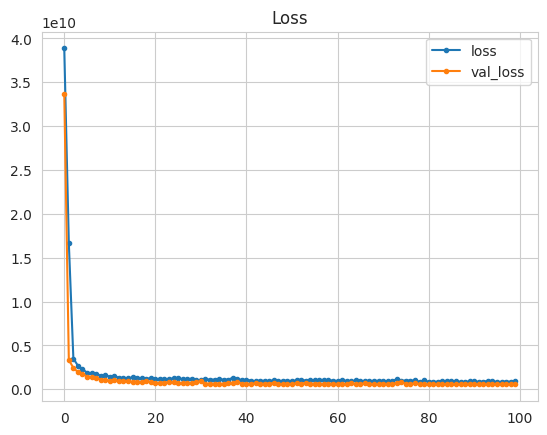

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.show()


In [17]:
model.evaluate(X_test, y_test)


10/10 [==============================] - 0s 991us/step - loss: 1524973824.0000


1524973824.0

In [18]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train,
                           X_val, y_val,
                           X_test, y_test, pipeline):

    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Validation Set")
    regression_evaluation(X_val, y_val, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    """
    # Gets features and target (either from train or test set) and pipeline
    - it predicts using the pipeline and the features
    - calculates performance metrics comparing the prediction to the target
    """
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3)
        )
    print("\n")


def regression_evaluation_plots(X_train, y_train,
                                X_val, y_val,
                                X_test, y_test,
                                pipeline, alpha_scatter=0.5):

    pred_train = pipeline.predict(X_train).reshape(-1)
    # we reshape the prediction arrays to be in the format (n_rows,),
    # so we can plot it after
    pred_val = pipeline.predict(X_val).reshape(-1)
    pred_test = pipeline.predict(X_test).reshape(-1)

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_val, y=pred_val, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_val, y=y_val, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Validation Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[2])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[2])
    axes[2].set_xlabel("Actual")
    axes[2].set_ylabel("Predictions")
    axes[2].set_title("Test Set")

    plt.show()
    train_valid_test = fig


Model Evaluation 

* Train Set
R2 Score: 0.893
Mean Absolute Error: 16214.523
Mean Squared Error: 676408174.2
Root Mean Squared Error: 26007.848


* Validation Set
R2 Score: 0.896
Mean Absolute Error: 16794.418
Mean Squared Error: 568299532.531
Root Mean Squared Error: 23839.034


* Test Set
R2 Score: 0.779
Mean Absolute Error: 21942.751
Mean Squared Error: 1524973716.979
Root Mean Squared Error: 39050.912




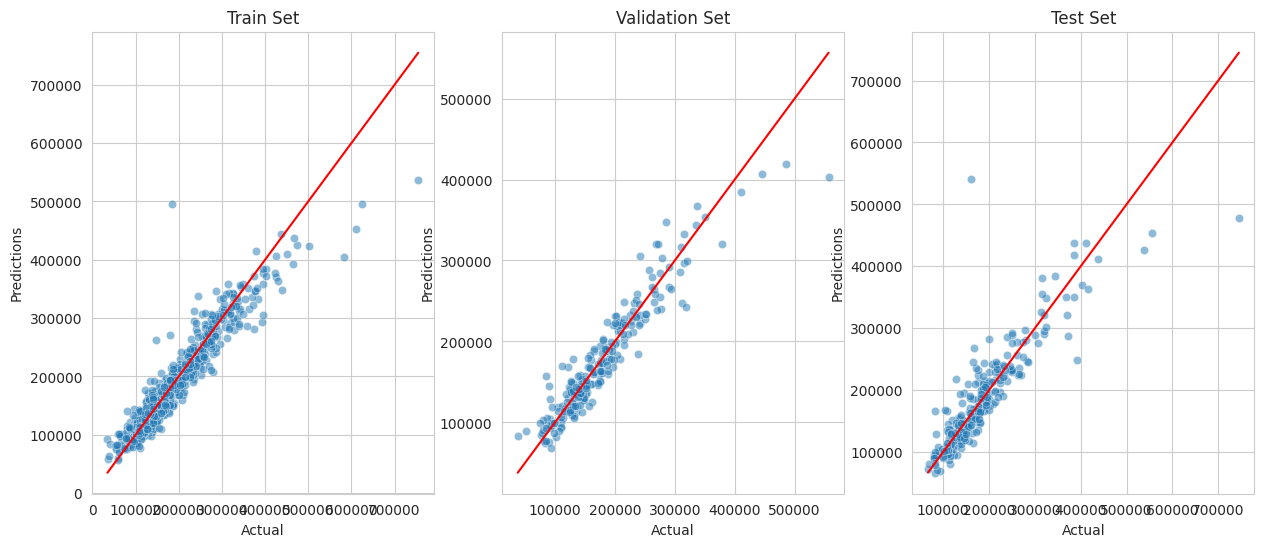

In [19]:
regression_performance(X_train, y_train, X_val, y_val, X_test, y_test, model)
regression_evaluation_plots(X_train, y_train, X_val, y_val, X_test, y_test,
                            model, alpha_scatter=0.5)


# Observations.

1. The recapitulate, our target is an R2 of 0.75 on train and test splits.

2. Different iterations of the train/test/validation split can have a marginal effect on the results

3. Retraining the model can produce a marginally different outcome, as much as 0.08 on the R2 score. 

4. Given points 2 & 3, it may take several iterations of splitting the data and training the model to get an R2 of 0.75 accross all three sets.

5. Hueristically, the model responds well to units which are a multiple of the number of features in the train set.

6. More than 4 deep layers adds little to the accuracy of the results.

7. The dropout layer makes very little difference, except at extreme settings ( 0.10 < or > 90).

8. The number of units in a layer significantly increases the accuracy of the model, up to a certain point, at which we see diminishing returns. There is little improvement in training time but an increase in time it takes to train the model. Given point 4 above, increased training time for little gain is undesireable.

9. Differing numbers of units between layers has either no effect or a diminishing effect on accuracy.

10. We have used ReLu for the activation function, in line with the source code. We have also tried sigmoid, linear and relu6, which either make no appreciable difference, or lead to significant underfitting.

11. Experimentation with using mean_absolute_error as a loss function revealed very little observable difference. We have kept the loss function as mse as it is the standard for regression tasks.

12. Using SGD as a optimizer led to the stop function kicking in between 10 - 20 epochs. Too short to properly train the model. We have used adam.

13. The stop function usually kicks in between 80 and 120 epochs. There is no observable pattern of improved results beyond this range. We have set the epochs at 100 as a resonable compromise.

14. Adjusting the other parameters of the stop function either led to it kicking in before the model could be properly trained, or incresing the trianing time for no improvement in performance.



Save the pipeline

In [20]:
import joblib
import os

try:
    os.makedirs(name=f'outputs/pipeline/')
except Exception as e:
    print(e)

joblib.dump(value=pipeline, filename=f"outputs/pipeline/pipeline.pkl")


['outputs/pipeline/pipeline.pkl']

Save the model

In [21]:
try:
    os.makedirs(name=f'outputs/model/')
except Exception as e:
    print(e)

model.save('outputs/model/house_price_predictor_model.h5')


---

# Predict Client House Prices


In [22]:
inherited_houses_clean_df = pd.read_csv(
        f"outputs/datasets/clean_data/Inherited_houses_clean.csv"
        )
inherited_houses_clean_df.head()


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd
0,896,0,2,No,468.0,Rec,270.0,730.0,Unf,1961.0,...,TA,11622,80.0,0.0,0,6,5,882.0,1961,1961
1,1329,0,3,No,923.0,ALQ,406.0,312.0,Unf,1958.0,...,Gd,14267,81.0,108.0,36,6,6,1329.0,1958,1958
2,928,701,3,No,791.0,GLQ,137.0,482.0,Fin,1997.0,...,TA,13830,74.0,0.0,34,5,5,928.0,1997,1998
3,926,678,3,No,602.0,GLQ,324.0,470.0,Fin,1998.0,...,Gd,9978,78.0,20.0,36,6,6,926.0,1998,1998


Put inherited_houses_clean_df through the pipeline

In [23]:
engineered_client_house_prices = pipeline.transform(inherited_houses_clean_df)


In [24]:
predictions = model.predict(engineered_client_house_prices)
predictions_df = pd.DataFrame(predictions)

house_price_predictions = pd.concat(
    [inherited_houses_clean_df, predictions_df], axis=1
    )
house_price_predictions


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,0
0,896,0,2,No,468.0,Rec,270.0,730.0,Unf,1961.0,...,11622,80.0,0.0,0,6,5,882.0,1961,1961,122753.312500
1,1329,0,3,No,923.0,ALQ,406.0,312.0,Unf,1958.0,...,14267,81.0,108.0,36,6,6,1329.0,1958,1958,188474.546875
2,928,701,3,No,791.0,GLQ,137.0,482.0,Fin,1997.0,...,13830,74.0,0.0,34,5,5,928.0,1997,1998,179881.578125
3,926,678,3,No,602.0,GLQ,324.0,470.0,Fin,1998.0,...,9978,78.0,20.0,36,6,6,926.0,1998,1998,193382.812500


In [25]:

import os
try:
    os.makedirs(name='outputs/datasets/predicted_prices')
except Exception as e:
    print(e)

house_price_predictions.to_csv(
    f"outputs/datasets/predicted_prices/house_price_predictions.csv",
    index=False
    )
